# NFL Big Data Bowl 2023

## Modeling

In [ ]:
# make imports and setup notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import plotly.graph_objects as go

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# initialize global variables
width = 53.3
length = 120
path = '/content/drive/MyDrive/NFLBigDataBowl2023/'

In [ ]:
# load data
scouting_df = pd.read_csv(path + 'pffScoutingData.csv')[['gameId', 'playId', 'nflId', 'pff_positionLinedUp']]
plays_df = pd.merge(pd.read_csv(path + 'plays.csv')[['gameId', 'playId', 'possessionTeam', 'passResult']], scouting_df.loc[scouting_df['pff_positionLinedUp'] == 'QB'].drop(columns='pff_positionLinedUp'))
weeks_df = []
for i in range(8):
    weeks_df.append(pd.read_csv(path + 'week%s.csv' % str(i+1)).drop(columns=['time', 'jerseyNumber', 'o', 'dir']).dropna())

In [ ]:
# sort data
plays_df = plays_df.sort_values(by=['gameId', 'playId'])
for i in range(8):
    weeks_df[i] = weeks_df[i].sort_values(by=['gameId', 'playId', 'frameId'])

In [ ]:
# make dictionary of play information
play_info = {}
plays_arr = plays_df.to_numpy()
for x in plays_arr:
    if x[0] not in play_info:
        play_info[x[0]] = {}
    play_info[x[0]][x[1]] = [x[2:]][0]

In [ ]:
# change coordinates so that offense goes right
for i in range(8):
    weeks_df[i].loc[weeks_df[i]['playDirection'] == 'left', 'x'] = abs(weeks_df[i]['x'] - length)
    weeks_df[i].loc[weeks_df[i]['playDirection'] == 'left', 'y'] = abs(weeks_df[i]['y'] - width)
    weeks_df[i] = weeks_df[i].drop(columns='playDirection')

In [ ]:
# feature engineering
data_list = []

for week in weeks_df:
    game_play = week[['gameId', 'playId']].drop_duplicates().to_numpy()
    week_arr = week.to_numpy()
    row = 0
    for tup in game_play:
        game = tup[0]
        play = tup[1]
        frame = -1
        time = 0
        play_on = False
        off = play_info[game][play][0]
        while row < len(week_arr) and week_arr[row, 0] == game and week_arr[row, 1] == play:
            if play_on and frame != week_arr[row, 3]:
                if week_arr[row, -1] == 'qb_sack' or week_arr[row, -1] == 'qb_strip_sack' or week_arr[row, -1] == 'run':
                    play_on == False
                idx = np.argsort(dist)
                add_players = [game, play, time]
                for j in range(6):
                    add_players.extend([dist[idx[j]], speed[idx[j]], accel[idx[j]]])
                data_list.append(add_players)
                time += .1
            if frame != week_arr[row, 3] and (play_on or week_arr[row, -1] == 'ball_snap'):
                play_on = True
                frame = week_arr[row, 3]
                dist = []
                speed = []
                accel = []
                idx = row
                while idx < len(week_arr) and week_arr[idx, 0] == game and week_arr[idx, 1] == play and week_arr[idx, 3] == frame:
                    if week_arr[idx, 2] == play_info[game][play][-1]:
                        qb = [week_arr[idx, 5], week_arr[idx, 6]]
                        break
                    else:
                        idx += 1
            elif frame != week_arr[row, 3]:
                frame = week_arr[row, 3]
            
            if play_on and week_arr[row, 4] != off:
                dist.append(np.sqrt((qb[0] - week_arr[row, 5])**2 + (qb[1] - week_arr[row, 6])**2))
                speed.append(week_arr[row, 7])
                accel.append(week_arr[row, 8])
            
            row += 1
            
data_arr = np.asarray(data_list)
cols = ['gameId', 'playId', 'time']
for i in range(6):
    cols.append('dist_%s' % i)
    cols.append('speed_%s' % i)
    cols.append('accel_%s' % i)
data_df = pd.DataFrame(data_arr, columns=cols)

In [ ]:
# select data for training
idx = np.zeros((len(data_arr)), dtype=bool)
y = []
for i, x in enumerate(data_arr):
    outcome = play_info[x[0]][x[1]][1]
    if outcome == 'C' or outcome == 'S' or outcome == 'R':
        idx[i] = True
        y.append([outcome == 'C'])

X = data_arr[idx, 2:]
y = np.asarray(y).ravel()

In [ ]:
# train model and get probabilities
idx = np.unique(data_arr[:, :2], axis=0).astype(int)
clf = XGBClassifier(random_state=42, verbosity=0).fit(X, y)
probs = clf.predict_proba(data_arr[:, 2:])
prob_dist = {}
for x in idx:
    if x[0] not in prob_dist:
        prob_dist[x[0]] = {}
    prob_dist[x[0]][x[1]] = []

for i in range(len(probs)):
    prob_dist[data_arr[i, 0]][data_arr[i, 1]].append(probs[i, 0])

In [ ]:
# get mean length
lengths = []
for x in idx:
    lengths.append(len(prob_dist[x[0]][x[1]]))

mean = sum(lengths) // len(lengths)

In [ ]:
# fit and transform pca
prob_dist_play = []
pca_prob_dist_play = []
train_pca_prob_dist_play = []
for x in idx:
    if len(prob_dist[x[0]][x[1]]) >= mean:
        train_pca_prob_dist_play.append(prob_dist[x[0]][x[1]][:mean])
    prob_dist_play.append(prob_dist[x[0]][x[1]])
    pca_prob_dist_play.append([0] * (mean - len(prob_dist[x[0]][x[1]][:mean])) + prob_dist[x[0]][x[1]][:mean])

pca = PCA().fit(np.asarray(train_pca_prob_dist_play))
pca_data = pca.transform(np.asarray(pca_prob_dist_play))
sing_val = pca.singular_values_

In [ ]:
# get scores
base_scores = []
bonus_scores = []
total_scores = []
for i, x in enumerate(pca_data):
    score = x @ sing_val.T / lengths[i]
    bonus = 0
    for j in range(max(lengths[i] - mean - 1, 0)):
        bonus -= abs(score * (1 - prob_dist_play[i][mean + j]))
    base_scores.append(score * 5)
    bonus_scores.append(bonus * 5)
    total_scores.append((score + bonus) * 5)

In [ ]:
# organize scores by play result
scores_by_result = {}
for result in plays_df.passResult.unique():
    scores_by_result[result] = []

for i, x in enumerate(idx):
    scores_by_result[play_info[x[0]][x[1]][1]].append(total_scores[i])

## Visualizations

In [ ]:
# import data for visualizations
viz_plays_df = pd.read_csv(path + 'plays.csv')
viz_players_df = pd.read_csv(path + 'players.csv')
viz_scouting_df = pd.read_csv(path + 'pffScoutingData.csv')
viz_weeks_df = []
for i in range(8):
    viz_weeks_df.append(pd.read_csv(path + 'week%s.csv' % (i+1)))

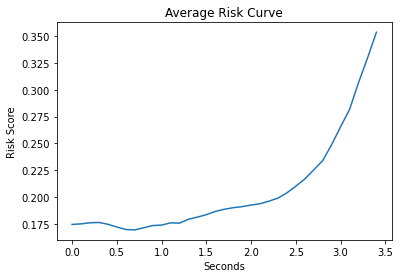

In [ ]:
# visualize average risk curve
avg = []
for i in range(mean):
    avg.append([])

for x in train_pca_prob_dist_play:
    for i in range(mean):
        avg[i].append(x[i])

for i in range(mean):
    avg[i] = sum(avg[i]) / len(avg[i])

x_avg = [x/10 for x in range(len(avg))]
plt.plot(x_avg, avg)
plt.xlabel('Seconds')
plt.ylabel('Risk Score')
plt.title('Average Risk Curve')
plt.show()

### Animation Helpers

In [ ]:
# colors for animations
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#CBB67C'
}

In [ ]:
# function to animate plays
def animate_play(tracking_df, play_df, players, pffScoutingData, gameId,playId):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)].copy()
    
    tracking_players_df = pd.merge(tracking_df,players,how="left",on = "nflId")
    tracking_players_df = pd.merge(tracking_players_df,pffScoutingData,how="left",on = ["nflId","playId","gameId"])
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId)&(tracking_players_df.gameId==gameId)].copy()

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()

    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0]
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    # initialize plotly start and stop buttons for animation
    updatemenus_dict = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]
    # initialize plotly slider to show frame position in animation
    sliders_dict = {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }


    frames = []
    for frameId in sorted_frame_list:
        data = []
        # Add Numbers to Field 
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        data.append(
            go.Scatter(
                x=np.arange(20,110,10), 
                y=[53.5-5]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add line of scrimage 
        data.append(
            go.Scatter(
                x=[line_of_scrimmage,line_of_scrimmage], 
                y=[0,53.5],
                line_dash='dash',
                line_color='blue',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Add First down line 
        data.append(
            go.Scatter(
                x=[first_down_marker,first_down_marker], 
                y=[0,53.5],
                line_dash='dash',
                line_color='yellow',
                showlegend=False,
                hoverinfo='none'
            )
        )
        # Plot Players
        for team in selected_tracking_df.team.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.team==team)&(selected_tracking_df.frameId==frameId)].copy()
            if team != "football":
                hover_text_array=[]
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_text_array.append("nflId:{}<br>displayName:{}<br>Position:{}<br>Role:{}".format(selected_player_df["nflId"].values[0],
                                                                                      selected_player_df["displayName"].values[0],
                                                                                      selected_player_df["pff_positionLinedUp"].values[0],
                                                                                      selected_player_df["pff_role"].values[0]))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hovertext=hover_text_array,hoverinfo="text"))
            else:
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[team],name=team,hoverinfo='none'))
        # add frame to slider
        slider_step = {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"}
        sliders_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    scale=10
    layout = go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),

        plot_bgcolor='#00B140',
        # Create title and add play description at the bottom of the chart for better visual appeal
        title=f"GameId: {gameId}, PlayId: {playId}<br>{gameClock} {quarter}Q"+"<br>"*19+f"{playDescription}",
        updatemenus=updatemenus_dict,
        sliders = [sliders_dict]
    )

    fig = go.Figure(
        data=frames[0]["data"],
        layout= layout,
        frames=frames[1:]
    )
    # Create First Down Markers 
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(
                    family="Courier New, monospace",
                    size=16,
                    color="black"
                    ),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

    return fig

### Animations

Total Score is: -12.825025964872697


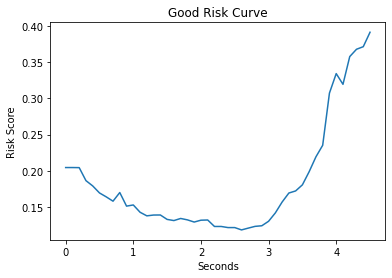

In [ ]:
# show risk curve of good play
print('Total Score is: %s' % total_scores[46])
good_play = prob_dist[2021090900][2397]
x_good = [x/10 for x in range(len(good_play))]
plt.plot(x_good, good_play)
plt.xlabel('Seconds')
plt.ylabel('Risk Score')
plt.title('Good Risk Curve')
plt.show()

In [ ]:
# show animation of good play
animate_play(viz_weeks_df[0], viz_plays_df, viz_players_df, viz_scouting_df, 2021090900, 2397).show()

Total Score is: 7.51745265517002


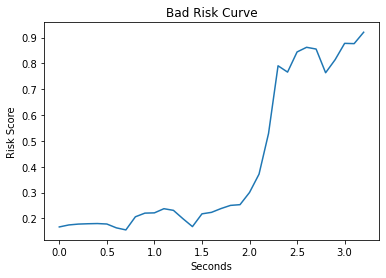

In [ ]:
# show risk curve of bad play
print('Total Score is: %s' % total_scores[251])
bad_play = prob_dist[2021091202][210]
x_bad = [x/10 for x in range(len(bad_play))]
plt.plot(x_bad, bad_play)
plt.xlabel('Seconds')
plt.ylabel('Risk Score')
plt.title('Bad Risk Curve')
plt.show()

In [ ]:
# show animation of bad play
animate_play(viz_weeks_df[0], viz_plays_df, viz_players_df, viz_scouting_df, 2021091202, 210).show()